## 환경설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 01. 무비렌즈 데이터 탐색
- [추천 시스템에 사용될 모델 학습을 위해 가장 많은 예제로 사용되는 데이터](https://grouplens.org/datasets/movielens/100k/)

### ratings_df : 유저가 영화에 대해 평가한 평점을 1.0 ~ 5.0 사이의 점수로 직접 표현

In [2]:
path = "../data/ml-100k/"
ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
print(ratings_df.shape)
ratings_df.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### timestamp 변수를 datetime 형식으로 변경
- 보통 과거 데이터를 기반으로 학습 후 현재 혹은 미래에 추천이 이루어지기 때문에 시간은 Train 데이터와 Test 데이터를 나눌 때 중요하게 사용된다.

In [3]:
from datetime import datetime
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['date'] = ratings_df['datetime'].dt.strftime('%Y-%m-%d').astype(str)

In [4]:
ratings_df

,user_id,movie_id,rating,timestamp,datetime,date
0,196,242,3,881250949,1997-12-04 15:55:49,1997-12-04
1,186,302,3,891717742,1998-04-04 19:22:22,1998-04-04
2,22,377,1,878887116,1997-11-07 07:18:36,1997-11-07
3,244,51,2,880606923,1997-11-27 05:02:03,1997-11-27
4,166,346,1,886397596,1998-02-02 05:33:16,1998-02-02
...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44,1997-11-22
99996,716,204,5,879795543,1997-11-17 19:39:03,1997-11-17
99997,276,1090,1,874795795,1997-09-20 22:49:55,1997-09-20
99998,13,225,2,882399156,1997-12-17 22:52:36,1997-12-17


#### 평점 데이터 기초 통계량
- 데이터에 대한 기본적인 통계정보 확인
- 몇 가지 지표에 대한 시각화 수행

In [5]:
n_user = len(ratings_df['user_id'].unique())
n_movie = len(ratings_df['movie_id'].unique())
print("사용자 수:", n_user, ', 영화 수:', n_movie)

사용자 수: 943 , 영화 수: 1682


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
user_id      100000 non-null int64
movie_id     100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
datetime     100000 non-null datetime64[ns]
date         100000 non-null object
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.6+ MB


In [7]:
ratings_df['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

#### 평점 데이터의 분포

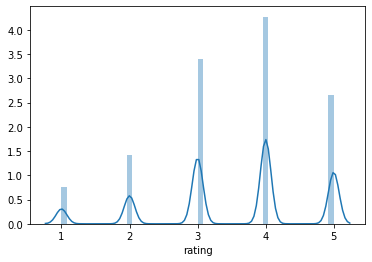

In [8]:
sns.distplot(ratings_df['rating'])
plt.show()

#### 사용자 별로 aggregate한 데이터 확인

In [9]:
user_statistics = pd.DataFrame({
    'numRating' : ratings_df.groupby('user_id')['movie_id'].nunique(),
    'avgRating' : ratings_df.groupby('user_id')['rating'].mean(),
    'stdRating' : ratings_df.groupby('user_id')['rating'].std()
}).reset_index()

user_statistics.head()

,user_id,numRating,avgRating,stdRating
0,1,272,3.610294,1.263585
1,2,62,3.709677,1.030472
2,3,54,2.796296,1.219026
3,4,24,4.333333,0.916831
4,5,175,2.874286,1.362963


#### 사용자의 평균 평점 분포

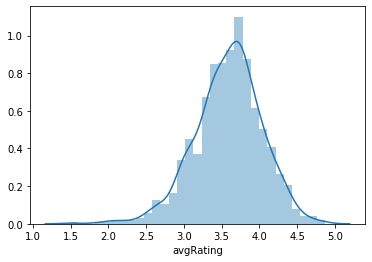

In [10]:
sns.distplot(user_statistics['avgRating'])
plt.show()

#### 사용자의 평가 영화 개수

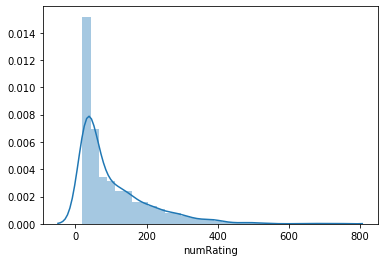

In [11]:
sns.distplot(user_statistics['numRating'])
plt.show()

### movies_df : 영화에 대한 제목, 장르, 연도 등

In [12]:
path = "../data/ml-100k/"
movies_df = pd.read_csv(path + 'u.item', sep='|', encoding='latin-1', header=None)
movies_df.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western']
print(movies_df.shape)
movies_df.head()

(1682, 24)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### users_df : 유저에 대한 성별, 연령, 직업, 주소 등

In [13]:
path = "../data/ml-100k/"
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
print(users_df.shape)
users_df.head()

(943, 5)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# 02. 인기도 기반 영화 추천(Popular, Highly Rated)
- **`Popular`** : 가장 많은 유저가 본 영화 (혹은 가장 많은 평가를 받은 영화)
- **`Highly Rated`** : 가장 높은 평점을 받은 영화

#### 영화 ranking을 위한 영화별 통계량 계산

In [14]:
movie_statistics = pd.DataFrame({
    'numUsers' : ratings_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating' : ratings_df.groupby('movie_id')['rating'].mean(),
    'stdRating' : ratings_df.groupby('movie_id')['rating'].std()
}).reset_index()

movie_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446


#### 영화별 평가 개수 분포

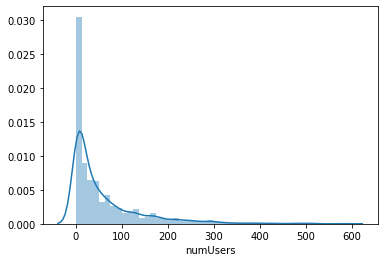

In [15]:
sns.distplot(movie_statistics['numUsers'])
plt.show()

#### 영화별 평균 평점의 분포

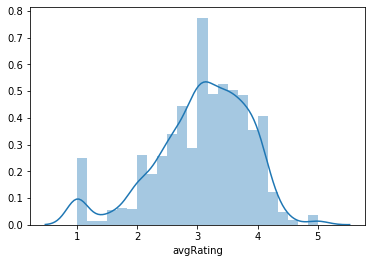

In [16]:
sns.distplot(movie_statistics['avgRating'])
plt.show()

## Popular - 가장 많은 유저가 본 영화 Top 10

In [17]:
top10_df = movie_statistics.sort_values(by='numUsers', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,50,583,4.358491,0.881341,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,Independence Day (ID4) (1996),03-Jul-1996


### Hacker News Formula

In [18]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
movies_df['age'] = (datetime.now() - movies_df['release_date']).dt.days
movie_statistics = pd.merge(movie_statistics, movies_df[['movie_id', 'age']], how='inner', on='movie_id')

In [19]:
movie_statistics['hackerNewsScore'] = (movie_statistics['numUsers'] - 1) / (np.power((movie_statistics['age'] + 2), 1.8)) 

In [20]:
top10_df = movie_statistics.sort_values(by='hackerNewsScore', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,movie_title,release_date
0,258,509,3.803536,0.994427,8780.0,0.000040,Contact (1997),1997-07-11
1,181,507,4.007890,0.923955,8899.0,0.000039,Return of the Jedi (1983),1997-03-14
2,100,508,4.155512,0.975756,8927.0,0.000039,Fargo (1996),1997-02-14
3,294,485,3.156701,1.098544,8892.0,0.000038,Liar Liar (1997),1997-03-21
4,288,478,3.441423,1.113910,8983.0,0.000036,Scream (1996),1996-12-20
5,286,481,3.656965,1.169401,9018.0,0.000036,"English Patient, The (1996)",1996-11-15
6,300,431,3.631090,0.998072,8971.0,0.000033,Air Force One (1997),1997-01-01
7,121,429,3.438228,1.116584,9153.0,0.000032,Independence Day (ID4) (1996),1996-07-03
8,1,452,3.878319,0.927897,9702.0,0.000030,Toy Story (1995),1995-01-01
9,237,384,3.710938,0.937908,8990.0,0.000029,Jerry Maguire (1996),1996-12-13


In [21]:
movies_df.drop(['age'], axis=1, inplace=True)

## Highly Rated - 평점이 가장 높은 영화 Top 10

In [22]:
top10_df = movie_statistics.sort_values(by='avgRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,movie_title,release_date
0,814,1,5.0,NaN,10067.0,0.000000e+00,"Great Day in Harlem, A (1994)",1994-01-01
1,1599,1,5.0,NaN,9207.0,0.000000e+00,Someone Else's America (1995),1996-05-10
2,1201,1,5.0,NaN,9245.0,0.000000e+00,Marlene Dietrich: Shadow and Light (1996),1996-04-02
3,1122,1,5.0,NaN,30156.0,0.000000e+00,They Made Me a Criminal (1939),1939-01-01
4,1653,1,5.0,NaN,9067.0,0.000000e+00,Entertaining Angels: The Dorothy Day Story (1996),1996-09-27
5,1293,3,5.0,0.0,8591.0,1.657942e-07,Star Kid (1997),1998-01-16
6,1500,2,5.0,0.0,9025.0,7.586157e-08,Santa with Muscles (1996),1996-11-08
7,1189,3,5.0,0.0,8948.0,1.540808e-07,Prefontaine (1997),1997-01-24
8,1536,1,5.0,NaN,9134.0,0.000000e+00,Aiqing wansui (1994),1996-07-22
9,1467,2,5.0,0.0,10432.0,5.845054e-08,"Saint of Fort Washington, The (1993)",1993-01-01


### 평점이 가장 높은 영화 Top 10 with 사용자 수 Threshold(10)

In [23]:
top10_df = movie_statistics[movie_statistics.numUsers > 10].sort_values(by='avgRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,movie_title,release_date
0,408,112,4.491071,0.771047,9219.0,0.000008,"Close Shave, A (1995)",1996-04-28
1,318,298,4.466443,0.829109,10432.0,0.000017,Schindler's List (1993),1993-01-01
2,169,118,4.466102,0.823607,10432.0,0.000007,"Wrong Trousers, The (1993)",1993-01-01
3,483,243,4.456790,0.728114,29060.0,0.000002,Casablanca (1942),1942-01-01
4,114,67,4.447761,0.764429,9242.0,0.000005,Wallace & Gromit: The Best of Aardman Animatio...,1996-04-05
5,64,283,4.445230,0.767008,10067.0,0.000018,"Shawshank Redemption, The (1994)",1994-01-01
6,603,209,4.387560,0.712551,24677.0,0.000003,Rear Window (1954),1954-01-01
7,12,267,4.385768,0.825500,9477.0,0.000018,"Usual Suspects, The (1995)",1995-08-14
8,50,583,4.358491,0.881341,16276.0,0.000015,Star Wars (1977),1977-01-01
9,178,125,4.344000,0.719588,23581.0,0.000002,12 Angry Men (1957),1957-01-01


### Steam Rating

In [24]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                  * np.power(2, -np.log10(movie_statistics['numUsers']))
top10_df = movie_statistics.sort_values(by='steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,steamRating,movie_title,release_date
0,318,298,4.466443,0.829109,10432.0,0.000017,4.202535,Schindler's List (1993),1993-01-01
1,64,283,4.445230,0.767008,10067.0,0.000018,4.181064,"Shawshank Redemption, The (1994)",1994-01-01
2,483,243,4.456790,0.728114,29060.0,0.000002,4.178012,Casablanca (1942),1942-01-01
3,50,583,4.358491,0.881341,16276.0,0.000015,4.158731,Star Wars (1977),1977-01-01
4,408,112,4.491071,0.771047,9219.0,0.000008,4.130806,"Close Shave, A (1995)",1996-04-28
5,12,267,4.385768,0.825500,9477.0,0.000018,4.127995,"Usual Suspects, The (1995)",1995-08-14
6,169,118,4.466102,0.823607,10432.0,0.000007,4.117391,"Wrong Trousers, The (1993)",1993-01-01
7,603,209,4.387560,0.712551,24677.0,0.000003,4.109705,Rear Window (1954),1954-01-01
8,98,390,4.289744,0.836597,11163.0,0.000020,4.075694,"Silence of the Lambs, The (1991)",1991-01-01
9,127,413,4.283293,0.934577,18103.0,0.000009,4.073956,"Godfather, The (1972)",1972-01-01


## 휴리스틱 랭킹 스코어
- Popular와 Highly Rated를 모두 고려하고 싶다면 각 Ranking 스코어를 조합하여 휴리스틱한 스코어를 만든다.
- 보통 Popular 스코어는 크게 증가하기 때문에 log 함수를 사용하고 Rating 스코어는 지수를 사용해서 그 정도를 조정해준다.

#### score = log(numUsers) * (avgRating) ^ alpha

In [25]:
alpha = 0.8
movie_statistics['score'] = np.log(movie_statistics['numUsers']) * np.power(movie_statistics['avgRating'], alpha)
top10_df = movie_statistics.sort_values(by = 'score', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,steamRating,score,movie_title,release_date
0,50,583,4.358491,0.881341,16276.0,0.000015,4.158731,20.676866,Star Wars (1977),1977-01-01
1,100,508,4.155512,0.975756,8927.0,0.000039,3.978408,19.472478,Fargo (1996),1997-02-14
2,127,413,4.283293,0.934577,18103.0,0.000009,4.073956,19.287119,"Godfather, The (1972)",1972-01-01
3,174,420,4.252381,0.891819,14815.0,0.000013,4.049117,19.229190,Raiders of the Lost Ark (1981),1981-01-01
4,98,390,4.289744,0.836597,11163.0,0.000020,4.075694,19.126654,"Silence of the Lambs, The (1991)",1991-01-01
5,181,507,4.007890,0.923955,8899.0,0.000039,3.853320,18.911102,Return of the Jedi (1983),1997-03-14
6,318,298,4.466443,0.829109,10432.0,0.000017,4.202535,18.863522,Schindler's List (1993),1993-01-01
7,172,367,4.204360,0.922803,15181.0,0.000011,4.000789,18.629723,"Empire Strikes Back, The (1980)",1980-01-01
8,313,350,4.245714,0.946822,8971.0,0.000027,4.032126,18.625375,Titanic (1997),1997-01-01
9,64,283,4.445230,0.767008,10067.0,0.000018,4.181064,18.621458,"Shawshank Redemption, The (1994)",1994-01-01


## 장르별 추천
- 전체 영화에 대해 랭킹을 구할수도 있지만, 장르별로 평점의 분포와 경향성이 다르기 때문에 장르 내에서 추천을 수행하기도 한다.

In [26]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

#### 장르별 평균 평점

In [27]:
rating_df_with_genre = pd.merge(ratings_df, movies_df, how='inner', on ='movie_id')

result = []

for genre in genre_list:
    numUser = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].count()
    avg = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].mean()
    std = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].std()
    result.append([numUser, avg, std])

genre_statistics = pd.DataFrame(result, index = genre_list, columns = ['numUsers', 'avgRating', 'stdRating'])
genre_statistics.sort_values(by='avgRating', ascending=False)

,numUsers,avgRating,stdRating
Film-Noir,1733,3.921523,0.993433
War,9398,3.815812,1.080271
Drama,39895,3.687379,1.079125
Documentary,758,3.672823,1.180455
Mystery,5245,3.638132,1.091117
Crime,8055,3.632278,1.112540
Romance,19461,3.621705,1.096125
Western,1854,3.613269,1.041946
Animation,3605,3.576699,1.096615
Sci-Fi,12730,3.560723,1.133190


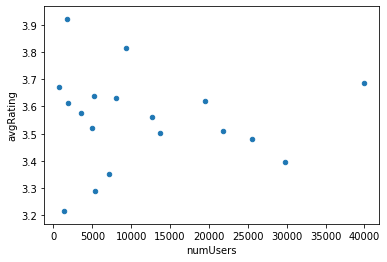

In [28]:
genre_statistics.plot.scatter(x='numUsers', y='avgRating')
plt.show()

### 장르별 steamRating을 이용해 Top 10 구하기

In [29]:
# genre별 steamRating을 이용해 top 10 구하기

genre = "Action"
# genre = "Fantasy"
# genre = "Romance"

movie_statistics_with_genre = pd.merge(movie_statistics, movies_df, how='inner', on ='movie_id')
top10_df_genre = movie_statistics_with_genre[movie_statistics_with_genre[genre] == 1].sort_values(by = 'steamRating', ascending=False)[:10]
top10_df_genre

,movie_id,numUsers,avgRating,stdRating,age,hackerNewsScore,steamRating,score,movie_title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,583,4.358491,0.881341,16276.0,0.000015,4.158731,20.676866,Star Wars (1977),1977-01-01,...,0,0,0,0,0,1,1,0,1,0
126,127,413,4.283293,0.934577,18103.0,0.000009,4.073956,19.287119,"Godfather, The (1972)",1972-01-01,...,0,0,0,0,0,0,0,0,0,0
173,174,420,4.252381,0.891819,14815.0,0.000013,4.049117,19.229190,Raiders of the Lost Ark (1981),1981-01-01,...,0,0,0,0,0,0,0,0,0,0
312,313,350,4.245714,0.946822,8971.0,0.000027,4.032126,18.625375,Titanic (1997),1997-01-01,...,0,0,0,0,0,1,0,0,0,0
171,172,367,4.204360,0.922803,15181.0,0.000011,4.000789,18.629723,"Empire Strikes Back, The (1980)",1980-01-01,...,0,0,0,0,0,1,1,0,1,0
172,173,324,4.172840,0.998948,12624.0,0.000013,3.967019,18.127130,"Princess Bride, The (1987)",1987-01-01,...,0,0,0,0,0,1,0,0,0,0
514,515,201,4.203980,0.901767,8878.0,0.000016,3.960037,16.729198,"Boot, Das (1981)",1997-04-04,...,0,0,0,0,0,0,0,0,1,0
186,187,209,4.186603,0.919141,17372.0,0.000005,3.948989,16.796565,"Godfather: Part II, The (1974)",1974-01-01,...,0,0,0,0,0,0,0,0,0,0
21,22,297,4.151515,0.962440,9291.0,0.000021,3.944074,17.781252,Braveheart (1995),1996-02-16,...,0,0,0,0,0,0,0,0,1,0
497,498,152,4.184211,0.758362,25773.0,0.000002,3.923218,15.788109,"African Queen, The (1951)",1951-01-01,...,0,0,0,0,0,1,0,0,1,0


## 사용자 데모그래픽을 활용한 추천

In [30]:
demo_ratings_df = pd.merge(ratings_df, users_df, how='inner', on='user_id')

In [31]:
def age_map(x):
    if x < 20:
        return 10
    elif x >= 20 and x < 30:
        return 20
    elif x >= 30 and x < 40:
        return 30
    elif x >= 40 and x < 50:
        return 40
    elif x >= 50 and x < 60:
        return 50
    else:
        return 60

In [32]:
demo_ratings_df['age'] = demo_ratings_df['age'].apply(lambda x: age_map(x))

In [33]:
# 영화 ranking을 위한 영화별 통계량 계산

demo_movie_statistics = pd.DataFrame({
    'numUsers': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['user_id'].nunique(),
    'avgRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].mean(), 
    'stdRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].std()
}).reset_index()

demo_movie_statistics.head()

,gender,age,movie_id,numUsers,avgRating,stdRating
0,F,10,1,13,3.769231,1.091928
1,F,10,2,2,3.000000,1.414214
2,F,10,3,1,5.000000,NaN
3,F,10,4,2,2.500000,0.707107
4,F,10,5,2,4.500000,0.707107


In [34]:
demo_movie_statistics['steamRating'] = demo_movie_statistics['avgRating'] - (demo_movie_statistics['avgRating'] - 3.0) \
                                       * np.power(2, -np.log10(demo_movie_statistics['numUsers']))

### 연령별/성별 steamRating을 이용해 Top 10 구하기

In [35]:
gender = 'M'
age = 30

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by = 'steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,M,30,483,56,4.464286,0.659595,4.028404,Casablanca (1942),1942-01-01
1,M,30,50,118,4.347458,0.851114,4.026966,Star Wars (1977),1977-01-01
2,M,30,357,58,4.448276,0.729634,4.021690,One Flew Over the Cuckoo's Nest (1975),1975-01-01
3,M,30,603,48,4.479167,0.743470,4.017941,Rear Window (1954),1954-01-01
4,M,30,480,38,4.500000,0.687730,3.998202,North by Northwest (1959),1959-01-01
5,M,30,127,85,4.352941,0.959984,3.997747,"Godfather, The (1972)",1972-01-01
6,M,30,174,94,4.329787,0.794988,3.991090,Raiders of the Lost Ark (1981),1981-01-01
7,M,30,318,64,4.359375,0.997890,3.970666,Schindler's List (1993),1993-01-01
8,M,30,12,52,4.384615,0.820183,3.963151,"Usual Suspects, The (1995)",1995-08-14
9,M,30,192,30,4.500000,0.682288,3.961193,Raging Bull (1980),1980-01-01


In [36]:
gender = 'F'
age = 40

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by = 'steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,F,40,427,16,4.500000,0.632456,3.848949,To Kill a Mockingbird (1962),1962-01-01
1,F,40,100,22,4.363636,0.953463,3.825876,Fargo (1996),1997-02-14
2,F,40,318,14,4.500000,1.091928,3.822246,Schindler's List (1993),1993-01-01
3,F,40,197,18,4.388889,0.916444,3.807063,"Graduate, The (1967)",1967-01-01
4,F,40,483,14,4.428571,0.646206,3.783091,Casablanca (1942),1942-01-01
5,F,40,496,9,4.555556,0.726483,3.752714,It's a Wonderful Life (1946),1946-01-01
6,F,40,485,11,4.454545,0.687552,3.747843,My Fair Lady (1964),1964-01-01
7,F,40,435,14,4.285714,0.994490,3.704782,Butch Cassidy and the Sundance Kid (1969),1969-01-01
8,F,40,292,14,4.285714,0.611250,3.704782,Rosewood (1997),1997-02-21
9,F,40,132,13,4.307692,0.751068,3.703500,"Wizard of Oz, The (1939)",1939-01-01


# 03. 온라인 리테일 데이터 탐색
- 실제 커머스 데이터와 비슷한 UCI에서 제공하는 온라인 리테일 데이터
- 유저가 쇼핑몰에서 상품을 구매했던 트랜잭션 데이터
- 유저, 아이템에 대한 정보가 트랜잭션 데이터에 포함
- 유저가 아이템을 구매한 Implicit feedback만이 존재함
- 아이템에 대한 유저의 선호도 값은 따로 존재하지 않음

In [37]:
path = '../data/online_retail/'
parse_date = lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M')
retail_df = pd.read_csv(path + "online_retail.csv", encoding="utf-8", parse_dates = ['InvoiceDate'], date_parser = parse_date)

In [38]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### CustomerID가 non-null인 데이터만 활용

In [40]:
retail_df = retail_df[~retail_df['CustomerID'].isnull()]
retail_df = retail_df.astype({"CustomerID" : "object"})

#### 각 column에 대해서 unique한 값이 몇 개인지 확인

In [41]:
retail_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)

InvoiceNo      22190
InvoiceDate    20460
CustomerID      4372
Description     3896
StockCode       3684
UnitPrice        620
Quantity         436
Country           37
dtype: int64

#### 환불 데이터로 추정되는 데이터 제외

In [42]:
retail_df[retail_df.Quantity < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [43]:
retail_df = retail_df[retail_df.Quantity > 0]
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


### 기초 통계량 및 데이터 분포 확인

In [44]:
retail_df['ym'] = retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])
retail_df['hour'] = retail_df['InvoiceDate'].dt.hour

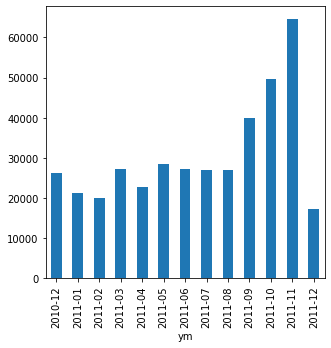

In [45]:
retail_df.groupby(['ym'])['InvoiceNo'].count().plot.bar(figsize=(5,5))
plt.show()

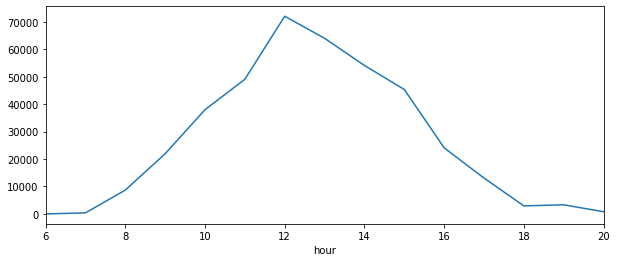

In [46]:
retail_df.groupby(['hour'])['InvoiceNo'].count().plot(figsize=(10,4))
plt.show()

### Item별 구매 횟수 / 구매 유저 수 확인

In [47]:
item_statistics = pd.DataFrame({
    'num_buys': retail_df.groupby('StockCode')['CustomerID'].count(),
    'num_users': retail_df.groupby('StockCode')['CustomerID'].nunique()
}).reset_index()

item_statistics.head()

,StockCode,num_buys,num_users
0,10002,49,40
1,10080,21,19
2,10120,30,25
3,10123C,3,3
4,10124A,5,5


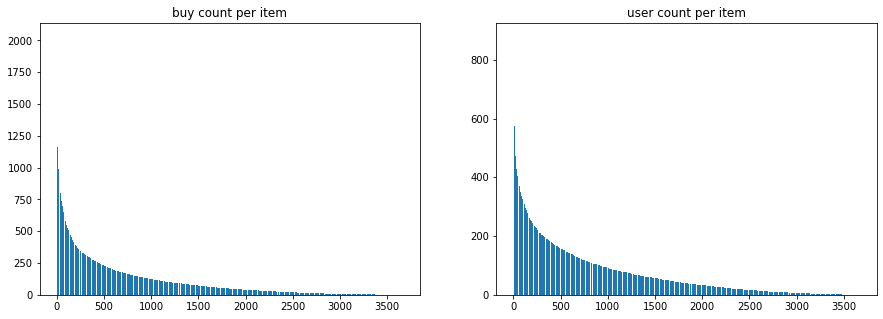

In [48]:
# 아이템 별 구매수 / 구매자 수 분포

fig, axs = plt.subplots(1,2, figsize=(15,5))

item_number_buys = item_statistics.sort_values(by='num_buys', ascending = False).reset_index()
axs[0].bar(item_number_buys.index, item_number_buys.num_buys)
axs[0].set_title('buy count per item')

item_number_users = item_statistics.sort_values(by='num_users', ascending = False).reset_index()
axs[1].bar(item_number_users.index, item_number_users.num_users)
axs[1].set_title('user count per item')
plt.show()

## 04. Popularity 기반 추천

### Popularity 기반 Top K개 아이템 추천 - 가장 많이 구매된 아이템 Top 10

In [49]:
item_statistics.sort_values(by='num_buys', ascending = False)[:10]

,StockCode,num_buys,num_users
3233,85123A,2035,856
1288,22423,1724,881
3219,85099B,1618,635
3059,84879,1408,678
2593,47566,1397,708
170,20725,1317,532
1570,22720,1159,640
172,20727,1105,458
3664,POST,1099,331
2033,23203,1098,505


### Popularity 기반 Top K개 아이템 추천 - 구매한 유저가 가장 많은 아이템 Top 10

In [50]:
item_statistics.sort_values(by='num_users', ascending = False)[:10]

,StockCode,num_buys,num_users
1288,22423,1724,881
3233,85123A,2035,856
2593,47566,1397,708
3059,84879,1408,678
1570,22720,1159,640
3219,85099B,1618,635
423,21212,1068,635
985,22086,1019,613
1321,22457,980,587
1035,22138,867,581


#### 나라별 가장 많이 조회된 인기 Top 10

In [51]:
for country in retail_df['Country'].unique():
    tmp_df = retail_df[(retail_df['Country'] == country)]
    tmp_statistics = pd.DataFrame({
        'num_buys': tmp_df.groupby('StockCode')['CustomerID'].count(),
        'num_users': tmp_df.groupby('StockCode')['CustomerID'].nunique()
    }).reset_index()
    print('Country', country, 'TOP 10')
    print(tmp_statistics.sort_values(by='num_buys', ascending=False)[:10], "\n")

Country United Kingdom TOP 10
     StockCode  num_buys  num_users
3229    85123A      1947        821
3215    85099B      1464        562
1286     22423      1426        767
3056     84879      1333        642
2591     47566      1308        659
169      20725      1147        454
171      20727      1049        426
1568     22720      1020        569
2031     23203       999        455
1252     22383       996        390 

Country France TOP 10
     StockCode  num_buys  num_users
1521      POST       300         72
1032     23084        73         29
315      21731        70         25
694      22554        68         29
696      22556        66         24
550      22326        62         25
57       20725        60         23
567      22352        56         19
111      21086        54         23
62       20750        54         26 

Country Australia TOP 10
    StockCode  num_buys  num_users
295     22720         9          2
90      21731         9          3
13      20725         

Country Finland TOP 10
    StockCode  num_buys  num_users
457      POST        37         12
436    84997D        10          3
435    84997C         8          2
313     23203         6          3
433    84997A         6          1
448    85099B         6          2
79      21430         5          4
102     21731         5          2
17      20750         5          4
155     22221         5          3 

Country Austria TOP 10
    StockCode  num_buys  num_users
305      POST        14          9
97      22139         4          4
110     22326         4          2
111     22328         4          2
16      20718         3          2
84      22029         3          2
114     22352         3          1
139     22554         3          2
141     22556         3          3
142     22557         3          3 

Country Greece TOP 10
    StockCode  num_buys  num_users
137      POST         3          2
23      21700         2          1
89      22922         2          1
106     23155     

### Time decay를 적용한 Popularity
- 단순히 그동안 일어난 구매 횟수를 더하는 것이 아니라, 추천을 수행하는 시간 기준으로 오래된 구매일수록 decay를 적용한다.

#### 추천을 제공하는 날짜가 2012-01-01이라고 하자

In [52]:
recommend_ts = pd.Timestamp(year=2012, month=1, day=1)
month_parameter = 0.95
day_parameter = 0.995

retail_df['decayMonth'] = month_parameter ** ((recommend_ts - retail_df['InvoiceDate']).dt.days/30)
retail_df['decayDay'] = day_parameter ** ((recommend_ts - retail_df['InvoiceDate']).dt.days)

In [53]:
retail_df[retail_df.ym =='2011-12'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ym,hour,decayMonth,decayDay
516403,579899,23301,GARDENERS KNEELING PAD KEEP CALM,24,2011-12-01 08:33:00,1.65,15687,United Kingdom,2011-12,8,0.95,0.860384
516404,579899,22623,BOX OF VINTAGE JIGSAW BLOCKS,3,2011-12-01 08:33:00,5.95,15687,United Kingdom,2011-12,8,0.95,0.860384
516405,579899,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,4,2011-12-01 08:33:00,3.75,15687,United Kingdom,2011-12,8,0.95,0.860384
516406,579899,23562,SET OF 6 RIBBONS PERFECTLY PRETTY,6,2011-12-01 08:33:00,2.89,15687,United Kingdom,2011-12,8,0.95,0.860384
516407,579899,71477,COLOURED GLASS STAR T-LIGHT HOLDER,4,2011-12-01 08:33:00,3.95,15687,United Kingdom,2011-12,8,0.95,0.860384


#### Time decay를 적용하는 경우 추천되는 아이템이 달라진다

In [54]:
item_statistics = pd.DataFrame({
    'num_buys': retail_df.groupby('StockCode')['InvoiceDate'].count(),
    'num_buys_decay_month': retail_df.groupby('StockCode')['decayMonth'].sum(),
    'num_buys_decay_day': retail_df.groupby('StockCode')['decayDay'].sum(),
}).reset_index()

item_statistics.head()

,StockCode,num_buys,num_buys_decay_month,num_buys_decay_day
0,10002,49,27.327934,8.972876
1,10080,21,17.433479,12.526036
2,10120,30,22.754610,14.838481
3,10123C,3,1.732293,0.611511
4,10124A,5,3.227024,1.577619


In [55]:
item_statistics.sort_values(by='num_buys', ascending = False)[:10]

,StockCode,num_buys,num_buys_decay_month,num_buys_decay_day
3233,85123A,2035,1455.381949,844.381886
1288,22423,1724,1237.365308,717.027522
3219,85099B,1618,1210.922568,750.774234
3059,84879,1408,1046.645812,646.264649
2593,47566,1397,1007.971560,568.718838
170,20725,1317,970.775197,581.563758
1570,22720,1159,840.528113,499.229100
172,20727,1105,831.297199,518.320445
3664,POST,1099,825.486100,520.147535
2033,23203,1098,887.730398,608.758673


In [56]:
item_statistics.sort_values(by='num_buys_decay_month', ascending = False)[:10]

,StockCode,num_buys,num_buys_decay_month,num_buys_decay_day
3233,85123A,2035,1455.381949,844.381886
1288,22423,1724,1237.365308,717.027522
3219,85099B,1618,1210.922568,750.774234
3059,84879,1408,1046.645812,646.264649
2593,47566,1397,1007.971560,568.718838
170,20725,1317,970.775197,581.563758
2033,23203,1098,887.730398,608.758673
985,22086,1019,855.166283,654.061759
1570,22720,1159,840.528113,499.229100
172,20727,1105,831.297199,518.320445


In [57]:
item_statistics.sort_values(by='num_buys_decay_day', ascending = False)[:10]

,StockCode,num_buys,num_buys_decay_month,num_buys_decay_day
3233,85123A,2035,1455.381949,844.381886
3219,85099B,1618,1210.922568,750.774234
1288,22423,1724,1237.365308,717.027522
985,22086,1019,855.166283,654.061759
3059,84879,1408,1046.645812,646.264649
2033,23203,1098,887.730398,608.758673
1919,23084,842,740.072077,594.450752
170,20725,1317,970.775197,581.563758
2593,47566,1397,1007.971560,568.718838
2039,23209,1029,823.387748,553.773448
